In [1]:
%load_ext autoreload
%autoreload 2
import telepot
bot = telepot.Bot('436447719:AAGq_iK2hE3cPFhmL9Jh53g9HyVkw3SXZbg')
def qq(txt):
    bot.sendMessage(1114926, txt)

In [2]:
qq('start')

In [3]:
import json
import gzip
from itertools import islice
from collections import Counter, defaultdict
from operator import itemgetter
import pyarrow.parquet as pq
import pyarrow as pa

import pandas as pd
from tqdm.notebook import tqdm
import dill
import os
from pqdm.processes import pqdm
import re

from workers import *
    
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec

import random
import collections

In [5]:
data_path = '..\\Data\\In\\'
submissions_path =  '..\\Submissions\\'

In [6]:
%%time
df = pd.read_parquet('df_text.pq')

CPU times: user 11.8 s, sys: 5.58 s, total: 17.3 s
Wall time: 14.8 s


In [7]:
%%time
df['text_list'] = df['processed_text'].apply(lambda x: x.split(' '))

CPU times: user 20.2 s, sys: 5.95 s, total: 26.2 s
Wall time: 26.2 s


In [8]:
df['txt_words'] = df['text_list'].apply(len)

In [9]:
df['txt_len'] = df['text_list'].apply(lambda x: sum([len(w) for w in x]))

In [10]:
df.head(2)

vacancy_id                       name  specializations  \
4     2700005  Разработчик Python/django  [137, 221, 296]   
5     2700006     Торговый представитель       [149, 242]   

                                          key_skills      employer  \
4                                                     845fe6266ab1   
5  работа текущий база клиент мерчендайзинг работ...  23ead4a8f164   

  groups_of_spec                                     processed_text  \
4            [1]  небольшой дружный команда требоваться опытный ...   
5           [17]  обязанность компания дистрибьютор продукт пита...   

                                            key_list  \
4                                                 []   
5  [работа, текущий, база, клиент, мерчендайзинг,...   

                      name_list  \
4  [Разработчик, Python/django]   
5     [Торговый, представитель]   

                                           text_list  txt_words  txt_len  
4  [небольшой, дружный, команда, требоваться, опы...         90      685  
5  [обязанность, компания, дистрибьютор, продукт,...         47      410

In [9]:
df[df['txt_words'] > 300].shape

(22410, 12)

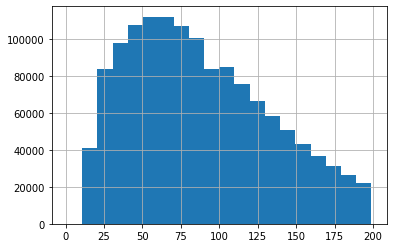

In [10]:
df[df['txt_words'] < 200]['txt_words'].hist(bins=20)

In [11]:
def txt_2_td(x):
    return TaggedDocument(x[1], [str(x[0])])

In [12]:
%%time
document_text = df[['vacancy_id', 'text_list']].apply(txt_2_td, axis = 1).to_list()

CPU times: user 55.2 s, sys: 578 ms, total: 55.8 s
Wall time: 55.8 s


In [13]:
document_text[0]

TaggedDocument(words=['небольшой', 'дружный', 'команда', 'требоваться', 'опытный', 'python', 'django', 'разработка', 'сложный', 'интересный', 'информационный', 'система', 'искать', 'поиск', 'ответственный', 'человек', 'заинтересованный', 'совершенствование', 'собственный', 'профессиональный', 'навык', 'общительный', 'нацеливать', 'командный', 'работа', 'ожидать', 'опыт', 'промышленный', 'разработка', 'проект', 'использование', 'restful', 'хороший', 'владение', 'python', 'django', 'плюс', 'умение', 'оптимизировать', 'sql', 'запрос', 'опыт', 'работа', 'команда', 'знание', 'git', 'опыт', 'работа', 'баг', 'трекер', 'обязанность', 'разработка', 'back', 'end', 'разработка', 'архитектура', 'система', 'внутренний', 'публичный', 'api', 'новый', 'проект', 'реализация', 'новый', 'модуль', 'система', 'доработка', 'оптимизация', 'существующий', 'модуль', 'система', 'анализ', 'исправление', 'ошибка', 'использовать', 'python', 'django', 'celery', 'postgres', 'django', 'rest', 'framework', 'sentry', '

In [14]:
len(document_text)

1456325

In [16]:
model = Doc2Vec(vector_size=100, min_count=2, epochs=10)

In [18]:
Doc2Vec.load()

5

In [12]:
%%time
model.build_vocab(document_text)

CPU times: user 7min 58s, sys: 5.79 s, total: 8min 4s
Wall time: 8min 3s


In [17]:
qq('Vocab ready')

In [19]:
class ProgressMeter(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.batch = 0
    def on_epoch_begin(self, model):
        self.batch = 0
        print(f'Start epoch {self.epoch}')
        self.epoch += 1
        
#     def on_batch_begin(self, model):
#         print(f'Start batch {self.batch}')

    def on_epoch_end(self, model):
        self.epoch += 1
        

In [21]:
%%time
model.train(document_text, total_examples=model.corpus_count, epochs=model.epochs, callbacks=[ProgressMeter()])

Start epoch 0
Start epoch 2
Start epoch 4
Start epoch 6
Start epoch 8
Start epoch 10
Start epoch 12
Start epoch 14
Start epoch 16
Start epoch 18
CPU times: user 1h 26min 29s, sys: 4min 10s, total: 1h 30min 40s
Wall time: 40min 23s


In [22]:
qq('Model ready')

In [23]:
model.save(open('d2vmodel_100_e10.bin', 'wb'))

In [120]:
model = Doc2Vec(vector_size=50, min_count=3, epochs=20, window = 50, seed = 42, workers = 12, negative = 5)

In [121]:
%%time
model.build_vocab(document_text)

CPU times: user 7min 56s, sys: 4.78 s, total: 8min 1s
Wall time: 8min


In [122]:
qq('Vocab ready')

In [ ]:
%%time
model.train(document_text, total_examples=model.corpus_count, epochs=model.epochs, callbacks=[ProgressMeter()])

In [ ]:
qq('Model ready')

In [ ]:
model.save(open('d2vmodel50_mc3_e20_win150_neg5.bin', 'wb'))

In [11]:
model = Doc2Vec.load('models/vector_size:50_min_count:2_epochs:10_window:5_seed:42_workers:12_negative:5.bin')

In [39]:
dill.dump(document_text, open('tagged_docs.bin', 'wb'))

In [37]:
dill.dump(word_freq, open('word_freq.bin', 'wb'))

In [ ]:
#from gensim.test.utils`a import get_tmpfile

In [ ]:
#fname = get_tmpfile("my_doc2vec_model")

# Asserting model

In [13]:
import gc

In [14]:
gc.collect()

153

In [15]:
docs_ids = [tg.tags[0] for tg in document_text]

In [16]:
TOPN = 10 # len(model.docvecs)
FULL = len(model.docvecs)
def rank_calc(doc_id):
    inferred_vector = model.infer_vector(document_text[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=TOPN)
    try:
        rank = [docid for docid, sim in sims].index(document_text[doc_id].tags[0])
    except:
        rank = 11
#         sims = model.docvecs.most_similar([inferred_vector], topn=FULL)
#         rank = [docid for docid, sim in sims].index(document_text[doc_id].tags[0])
    
    return (doc_id, rank, sims)

In [42]:
# rank_res = pqdm(range(len(document_text)), rank_calc, n_jobs = 10)

In [17]:
num_samples = 100
doc_samples = random.sample(range(len(document_text)),num_samples)
low_bound = random.randint(0, len(document_text) - num_samples - 1)
result = []
for doc_id in tqdm(doc_samples, total=num_samples):
    result.append(rank_calc(doc_id))

In [16]:
import model_doc2vec
from model_doc2vec import ProgressMeter

In [9]:
document_text = dill.load(open('tagged_docs.bin','rb'))

In [17]:
import functools
import operator
full_text = functools.reduce(operator.iconcat, [d.words for d in document_text], [])

In [31]:
corpus_count = len(full_text)

In [32]:
word_freq = Counter(full_text)

In [35]:
model = Doc2Vec(vector_size=50, min_count=3, epochs=20, window = 50, seed = 42, workers = 12, negative = 5)

In [36]:
model.build_vocab_from_freq(word_freq)

In [91]:
# 0.689 0.179 vector_size:250, min_count:2, epochs:10, window:5, seed:42, workers:12, negative:5
# 0.758 0.113 vector_size:300, min_count:2, epochs:10, window:5, seed:42, workers:6, negative:5
# 0.774 0.097 vector_size:300, min_count:2, epochs:10, window:7, seed:42, workers:4, negative:10
# 0.767 0.112 vector_size:300, min_count:2, epochs:10, window:10, seed:42, workers:4, negative:15
# 0.768 0.088 vector_size:300, min_count:2, epochs:10, window:10, seed:42, workers:4, negative:30
# 0.816 0.042 vector_size:300, min_count:2, epochs:10, window:7, seed:42, workers:4, negative:30
# 0.845 0.026 vector_size:300, min_count:2, epochs:10, window:7, seed:42, workers:4, negative:50

In [18]:
model_doc2vec.train_model(document_text=document_text, vector_size=400, min_count=2, epochs=20, window = 5, seed = 42, workers = 4, negative = 20)
qq('done')

Preparing DOC2VEC model: vector_size:400, min_count:2, epochs:20, window:5, seed:42, workers:4, negative:20
Vocab ready
(1456325, 400)
Start epoch 0
Epoch  takes 0:08:18.877713. Estimate to end 2:37:58.676542
Start epoch 1
Epoch  takes 0:08:11.201424. Estimate to end 2:28:30.713648
Start epoch 2
Epoch  takes 0:08:07.016009. Estimate to end 2:19:30.207624
Start epoch 3
Epoch  takes 0:08:04.352037. Estimate to end 2:10:45.790633
Start epoch 4
Epoch  takes 0:08:03.638098. Estimate to end 2:02:15.257743
Start epoch 5
Epoch  takes 0:08:03.097979. Estimate to end 1:53:52.429411
Start epoch 6
Epoch  takes 0:08:07.266734. Estimate to end 1:45:42.980260
Start epoch 7
Epoch  takes 0:08:10.148791. Estimate to end 1:37:38.399792
Start epoch 8
Epoch  takes 0:08:07.581539. Estimate to end 1:29:29.444129
Start epoch 9
Epoch  takes 0:08:09.622017. Estimate to end 1:21:22.803725
Start epoch 10
Epoch  takes 0:08:07.429178. Estimate to end 1:13:13.827402
Start epoch 11
Epoch  takes 0:08:05.897867. Estima

In [19]:
model = Doc2Vec.load('models/vector_size:400_min_count:2_epochs:20_window:5_seed:42_workers:4_negative:20.bin')

In [20]:
model.docvecs.vectors_docs.shape

(1456325, 400)

In [21]:
train_indexes = model.docvecs.index2entity

In [22]:
train_vectors = model.docvecs.vectors_docs

In [23]:
dill.dump(train_indexes, open('train_indexes.bin', 'wb'))

In [24]:
dill.dump(train_vectors, open('train_vectors.bin', 'wb'))

In [25]:
test_df = pd.read_parquet('test_text.pq')

In [26]:
%%time
test_df['text_list'] = test_df['processed_text'].apply(lambda x: x.split(' '))

CPU times: user 25.3 s, sys: 6.37 s, total: 31.7 s
Wall time: 31.7 s


In [27]:
def inf_vec(txt):
    return model.infer_vector(txt)

In [28]:
import gc

In [29]:
gc.collect()

60

In [30]:
test_vector = pqdm(test_df['text_list'], inf_vec, n_jobs=11)

In [31]:
dill.dump(test_vector, open('test_vectors.bin', 'wb'))

In [32]:
dill.dump(test_df['vacancy_id'].to_list(), open('test_indexes.bin', 'wb'))

In [27]:
spec_df = df[['vacancy_id', 'specializations']].copy()

In [29]:
spec_df.set_index('vacancy_id', inplace=True)

In [35]:
dill.dump(spec_df.to_dict(orient='dict')['specializations'], open('train_spec.bin', 'wb'))

In [67]:
num_samples = 1000
TOPN = 10
doc_samples = random.sample(range(len(document_text)),num_samples)
ranks = []
for doc_id in doc_samples:
    inferred_vector = model.infer_vector(document_text[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=TOPN)
    try:
        ranks.append([docid for docid, sim in sims].index(document_text[doc_id].tags[0]))
    except:
        ranks.append(11)

In [18]:
# ranks = [x[1] for x in result]
# sims = [x[2] for x in result]

In [68]:
collections.Counter(ranks)

Counter({0: 679,
         2: 29,
         4: 7,
         11: 201,
         1: 57,
         3: 9,
         7: 5,
         9: 5,
         5: 4,
         8: 2,
         6: 2})

In [109]:
doc_id = random.randint(low_bound, low_bound+num_samples)
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(document_text[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(document_text[sims[index][0]].words)))

Document (487057): «обязанность продажа мебель интернет магазин прием входить заказ звонок осуществление холодный звонок консультирование покупатель телефон помощь подбор товар отслеживание заказ создание дизайн проект клиент поддержание высокий уровень сервис требование владение компьютер уровень пользователь высокий коммуникативный навык поставлять речь грамотность пунктуальность организованность нацеленность достижение результат условие заработный плата рубль интересный работа крупный компания дружный сплоченный коллектив официальный трудоустройство гарантия стабильность профессиональный карьерный рост бесплатный доставка офис обратно полный рабочий день график работа офис вариант работа удаленный гибкий график рассматриваться»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3):



IndexError: list index out of range

In [86]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(document_text) - 1)
inferred_vector = model.infer_vector(document_text[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

In [90]:
docs_ids.index(sims[index][0])

1245159

In [106]:
len(sims)

2912651

In [94]:
tag_to_id = {v.tags[0]:i for i,v in enumerate(document_text)}

In [100]:
len(sims)-1

2912650

In [97]:
document_text[tag_to_id[sims[index][0]]]

KeyError: 590579

In [104]:
tag_to_id

{2700005: 0,
 2700006: 1,
 2700007: 2,
 2700010: 3,
 2700015: 4,
 2700017: 5,
 2700022: 6,
 2700023: 7,
 2700024: 8,
 2700025: 9,
 2700027: 10,
 2700029: 11,
 2700030: 12,
 2700034: 13,
 2700037: 14,
 2700038: 15,
 2700041: 16,
 2700044: 17,
 2700046: 18,
 2700047: 19,
 2700048: 20,
 2700049: 21,
 2700051: 22,
 2700052: 23,
 2700053: 24,
 2700056: 25,
 2700057: 26,
 2700065: 27,
 2700067: 28,
 2700068: 29,
 2700069: 30,
 2700070: 31,
 2700072: 32,
 2700073: 33,
 2700075: 34,
 2700076: 35,
 2700078: 36,
 2700079: 37,
 2700081: 38,
 2700082: 39,
 2700088: 40,
 2700091: 41,
 2700098: 42,
 2700099: 43,
 2700100: 44,
 2700101: 45,
 2700105: 46,
 2700106: 47,
 2700108: 48,
 2700110: 49,
 2700113: 50,
 2700116: 51,
 2700119: 52,
 2700121: 53,
 2700124: 54,
 2700125: 55,
 2700127: 56,
 2700129: 57,
 2700130: 58,
 2700131: 59,
 2700133: 60,
 2700138: 61,
 2700141: 62,
 2700144: 63,
 2700145: 64,
 2700147: 65,
 2700148: 66,
 2700153: 67,
 2700155: 68,
 2700156: 69,
 2700158: 70,
 2700161: 71,
 2

In [103]:
tag_to_id[sims[index][0]]

KeyError: 590579

In [91]:
# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(document_text[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(document_text[docs_ids.index(sims[index][0])].words)))

Test Document (1240876): «требование опыт проведение аналогичный работа аккуратность пунктуальность исполнительность обязанность монтаж пожарный охранный сигнализация видеонаблюдение слаботочный система территория курск курский область условие спецодежда инструмент зарплата руб зависимость выполнять объем работа оклад премия официальный оформление оплачивать отпуск»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3):

MOST (2286673, 0.8033948540687561): «обязанность проведение работа склад обеспечение сохранность тмц требование опыт работа физический нагрузка ответственность организованность условие стабильный трудоустройство график работа место работа мурманск свердлов»



ValueError: 590579 is not in list